In [1]:
import pandas as pd
from holidays import country_holidays
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import seaborn as sns

# Importing files

In [2]:
salesDf = pd.read_csv("C:/Users/Admin/OneDrive - St. Clair College/Documents/DAB/DAB103 Project/20100041.csv", parse_dates=["REF_DATE"])
populationDf = pd.read_csv("C:/Users/Admin/OneDrive - St. Clair College/Documents/DAB/DAB103 Project/17100009.csv", parse_dates=["REF_DATE"])
householdIncomeDf = pd.read_csv("C:/Users/Admin/OneDrive - St. Clair College/Documents/DAB/DAB103 Project/36100435.csv", parse_dates=["REF_DATE"])

# Taking subset of columns which will be in use

In [3]:
salesDf = salesDf[["REF_DATE","Retail commodity classification","Retail trade sector","VALUE"]]
salesDf.rename(columns={"VALUE":"Sales"}, inplace=True)
salesDf["Sales"] = salesDf["Sales"]/1000 #*1000

# population

In [4]:
populationDf = populationDf[populationDf["GEO"]=="Canada"]
populationDf = populationDf[["REF_DATE","VALUE"]]
populationDf["VALUE"] = populationDf["VALUE"]/1000
populationDf.rename(columns={"VALUE":"Population"}, inplace=True)

# Household income

In [5]:
householdIncomeDf = householdIncomeDf[["REF_DATE","Seasonal adjustment","Estimates","VALUE"]]
householdIncomeDf.rename(columns={"VALUE":"Income"}, inplace=True)
householdIncomeDf["Income"] = householdIncomeDf["Income"] #*1000000
householdIncomeDf = householdIncomeDf[(householdIncomeDf["Seasonal adjustment"]=="Unadjusted" ) & (householdIncomeDf["Estimates"].isin(["Household income","Disposable income"]))]
householdIncomeDf = householdIncomeDf.set_index(['REF_DATE', 'Seasonal adjustment', 'Estimates'])['Income'].unstack()
householdIncomeDf.reset_index(drop=False, inplace=True)

# Merging Data

In [6]:
salesDf = salesDf.merge(populationDf, on="REF_DATE", how= "left")
salesDf = salesDf.merge(householdIncomeDf, on="REF_DATE", how= "inner")

# Adding Holiday Column

In [7]:
years = list(pd.DatetimeIndex(salesDf['REF_DATE']).year.unique())

nafta_holidays = country_holidays('CA', years=years)
dates = sorted(nafta_holidays.items(), key=lambda x: x[0])
holidays = pd.DataFrame(dates)
holidays.columns = ["Date","Name"]
holidays['Date'] = pd.to_datetime(holidays['Date'])
holidays['quarter'] = holidays['Date'].dt.to_period('Q')
holidays = holidays['quarter'].value_counts().rename_axis('quarter').reset_index(name='Holiday Count').sort_values(by=["quarter"])

salesDf["quarter"] = salesDf["REF_DATE"].dt.to_period('Q')

salesDf = salesDf.merge(holidays, on="quarter", how='left')

# Cleaning Data

In [8]:
salesDf.drop(columns=["quarter","Seasonal adjustment"], inplace=True)

salesDf["Retail commodity classification"] = salesDf["Retail commodity classification"].str.replace(r"(\s*\(.*?\)\s*)", "").str.strip()

C:\Users\Admin\AppData\Local\Temp\ipykernel_9572\454457294.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  salesDf["Retail commodity classification"] = salesDf["Retail commodity classification"].str.replace(r"(\s*\(.*?\)\s*)", "").str.strip()


# Visualizing Data

[Text(0, 0.5, 'Retail Category Classification'),
 Text(0.5, 0, 'Total Sales(millions)'),
 Text(0.5, 1.0, 'Total Sales by Retail Category')]

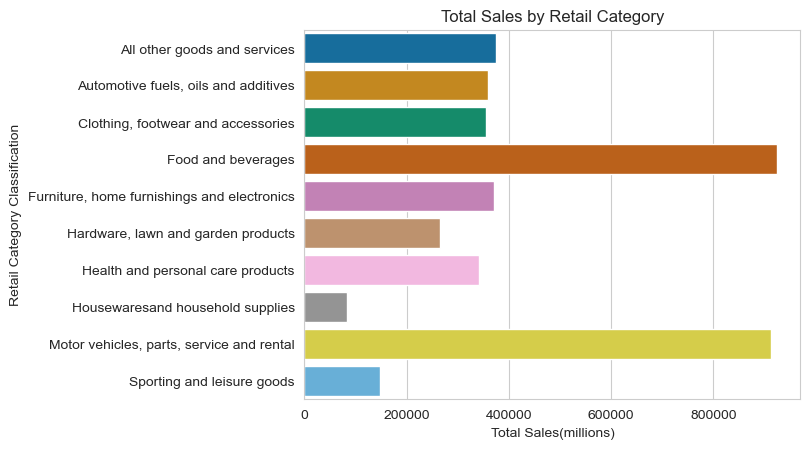

In [12]:
salesDfOverview = salesDf[(salesDf["Retail commodity classification"]!="Total commodities") & (salesDf["Retail trade sector"]=="Total retail trade, all stores")]
sns.set_style("whitegrid")
sns.set_palette("colorblind")
salesDfOverviewGroupby = salesDfOverview.groupby("Retail commodity classification").sum().reset_index()
ax = sns.barplot(data=salesDfOverviewGroupby, y="Retail commodity classification", x="Sales")
#plt.xticks(rotation=90)
ax.set(ylabel="Retail Category Classification", xlabel="Total Sales(millions)", title="Total Sales by Retail Category")


[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Sales(millions)'),
 Text(0.5, 1.0, 'Sales by Retail Commodity Over Time')]

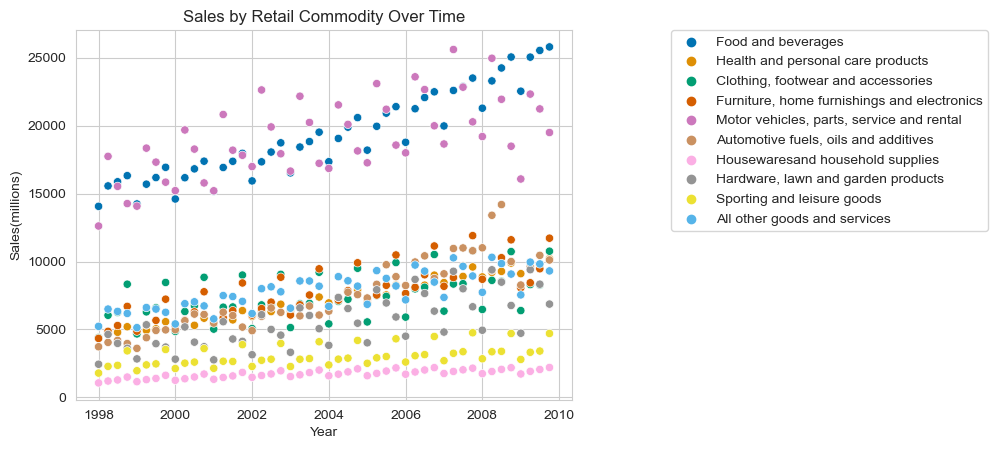

In [13]:
ax=sns.scatterplot(data=salesDfOverview, x="REF_DATE", y="Sales", hue="Retail commodity classification")
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0)
ax.set(xlabel="Year", ylabel="Sales(millions)", title="Sales by Retail Commodity Over Time")

[Text(0, 0.5, 'Population(thousands)')]

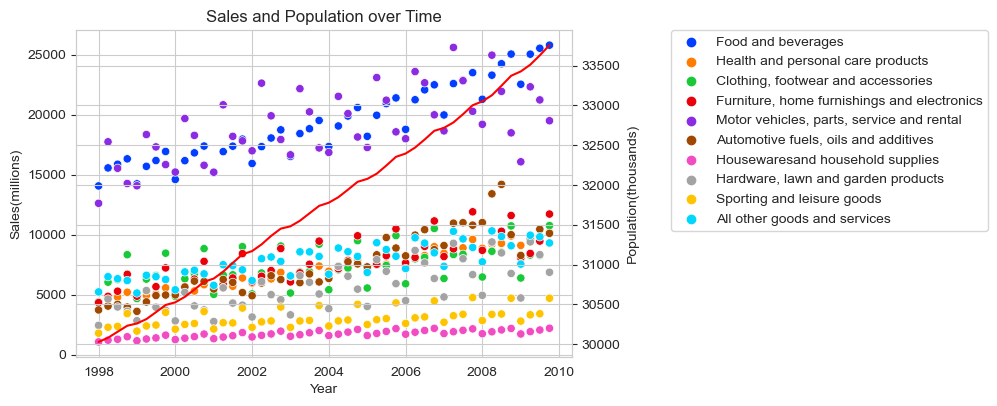

In [14]:
sns.set_style("whitegrid")
sns.set_palette("bright")
ax = sns.scatterplot(data=salesDfOverview, x="REF_DATE", y="Sales", hue="Retail commodity classification")
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0)
ax2 = ax.twinx()
salesDfOverview.plot(x="REF_DATE", y="Population", ax=ax2, legend=False, color="r")
ax.set(xlabel="Year", ylabel="Sales(millions)", title="Sales and Population over Time")
ax2.set(ylabel="Population(thousands)")

[Text(0, 0.5, 'Holiday Count')]

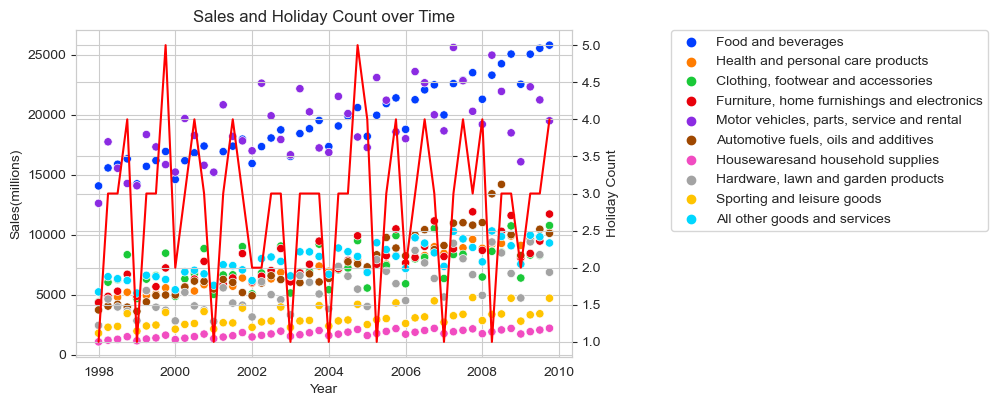

In [15]:
sns.set_style("whitegrid")
sns.set_palette("bright")
ax = sns.scatterplot(data=salesDfOverview, x="REF_DATE", y="Sales", hue="Retail commodity classification")
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0)
ax2 = ax.twinx()
salesDfOverview.plot(x="REF_DATE", y="Holiday Count", ax=ax2, legend=False, color="r")
ax.set(xlabel="Year", ylabel="Sales(millions)", title="Sales and Holiday Count over Time")
ax2.set(ylabel="Holiday Count")

Text(0, 0.5, 'Disposable Income(millions)')

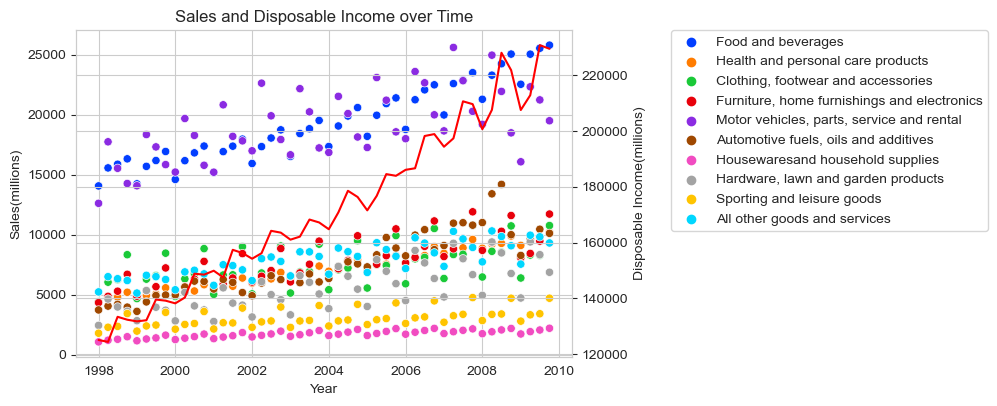

In [16]:
sns.set_style("whitegrid")
sns.set_palette("bright")
ax = sns.scatterplot(data=salesDfOverview, x="REF_DATE", y="Sales", hue="Retail commodity classification")
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0)
ax2 = ax.twinx()
salesDfOverview.plot(x="REF_DATE", y="Disposable income", ax=ax2, legend=False, color="r")
ax.set(xlabel="Year", ylabel="Sales(millions)", title="Sales and Disposable Income over Time")
ax2.set_ylabel("Disposable Income(millions)")

Text(0.5, 1.0, 'Sales by Retail Trade Sector over Time')

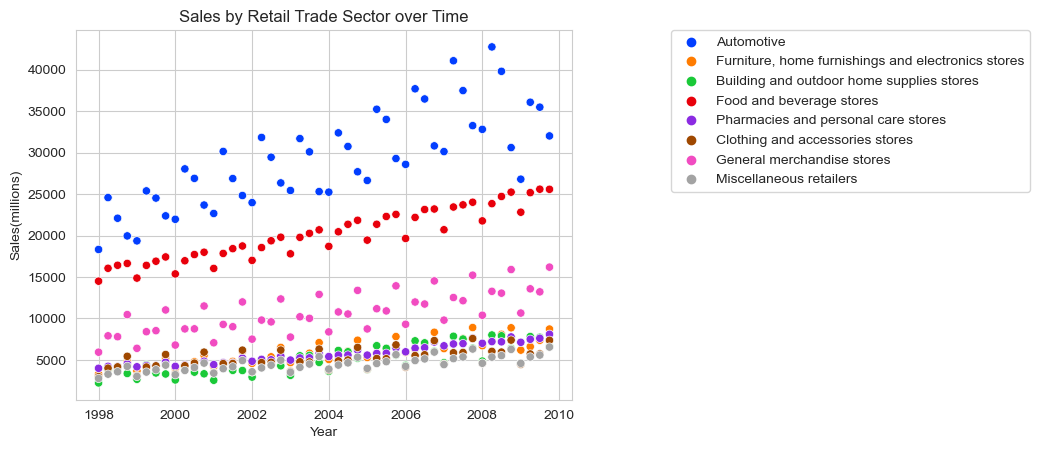

In [17]:
sns.set_style("whitegrid")
sns.set_palette("bright")
salesRetailSector = salesDf[(salesDf["Retail commodity classification"]=="Total commodities") & (salesDf["Retail trade sector"]!="Total retail trade, all stores")]
sns.scatterplot(data=salesRetailSector, x="REF_DATE", y="Sales", hue="Retail trade sector")
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Year")
plt.ylabel("Sales(millions)")
plt.title("Sales by Retail Trade Sector over Time")

Text(0.5, 1.0, 'Food and Beverage Sales by Retail Trade Sector over Time')

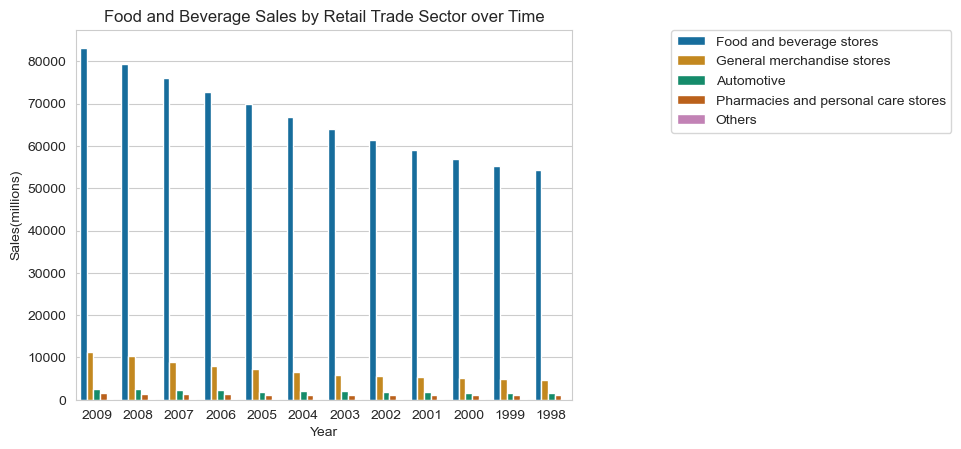

In [18]:
foodAndBev = salesDf[(salesDf["Retail commodity classification"]=="Food and beverages") & 
                     (salesDf["Retail trade sector"]!="Total retail trade, all stores")]
foodAndBev = foodAndBev.groupby([foodAndBev["REF_DATE"].dt.to_period('Y'), "Retail trade sector"]).sum().reset_index()
foodAndBev = foodAndBev[foodAndBev["Sales"]!=0]
foodAndBevOthers = foodAndBev[(foodAndBev["Retail trade sector"]=="Furniture, home furnishings and electronics stores") | (foodAndBev["Retail trade sector"]=="Miscellaneous retailers")]
foodAndBevOthers = foodAndBevOthers.groupby("REF_DATE").sum().reset_index()
foodAndBevOthers["Retail trade sector"] = "Others"
foodAndBevOthers["Holiday Count"] = foodAndBevOthers["Holiday Count"] /2
foodAndBev = foodAndBev[(foodAndBev["Retail trade sector"]!="Furniture, home furnishings and electronics stores") & (foodAndBev["Retail trade sector"]!="Miscellaneous retailers")]
foodAndBev = pd.concat([foodAndBev,foodAndBevOthers])
foodAndBev =foodAndBev.sort_values("Sales", ascending=False)
sns.set_style("whitegrid")
sns.set_palette("colorblind")
sns.barplot(data=foodAndBev, x="REF_DATE", y="Sales", hue="Retail trade sector")
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Year")
plt.ylabel("Sales(millions)")
plt.title("Food and Beverage Sales by Retail Trade Sector over Time")

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


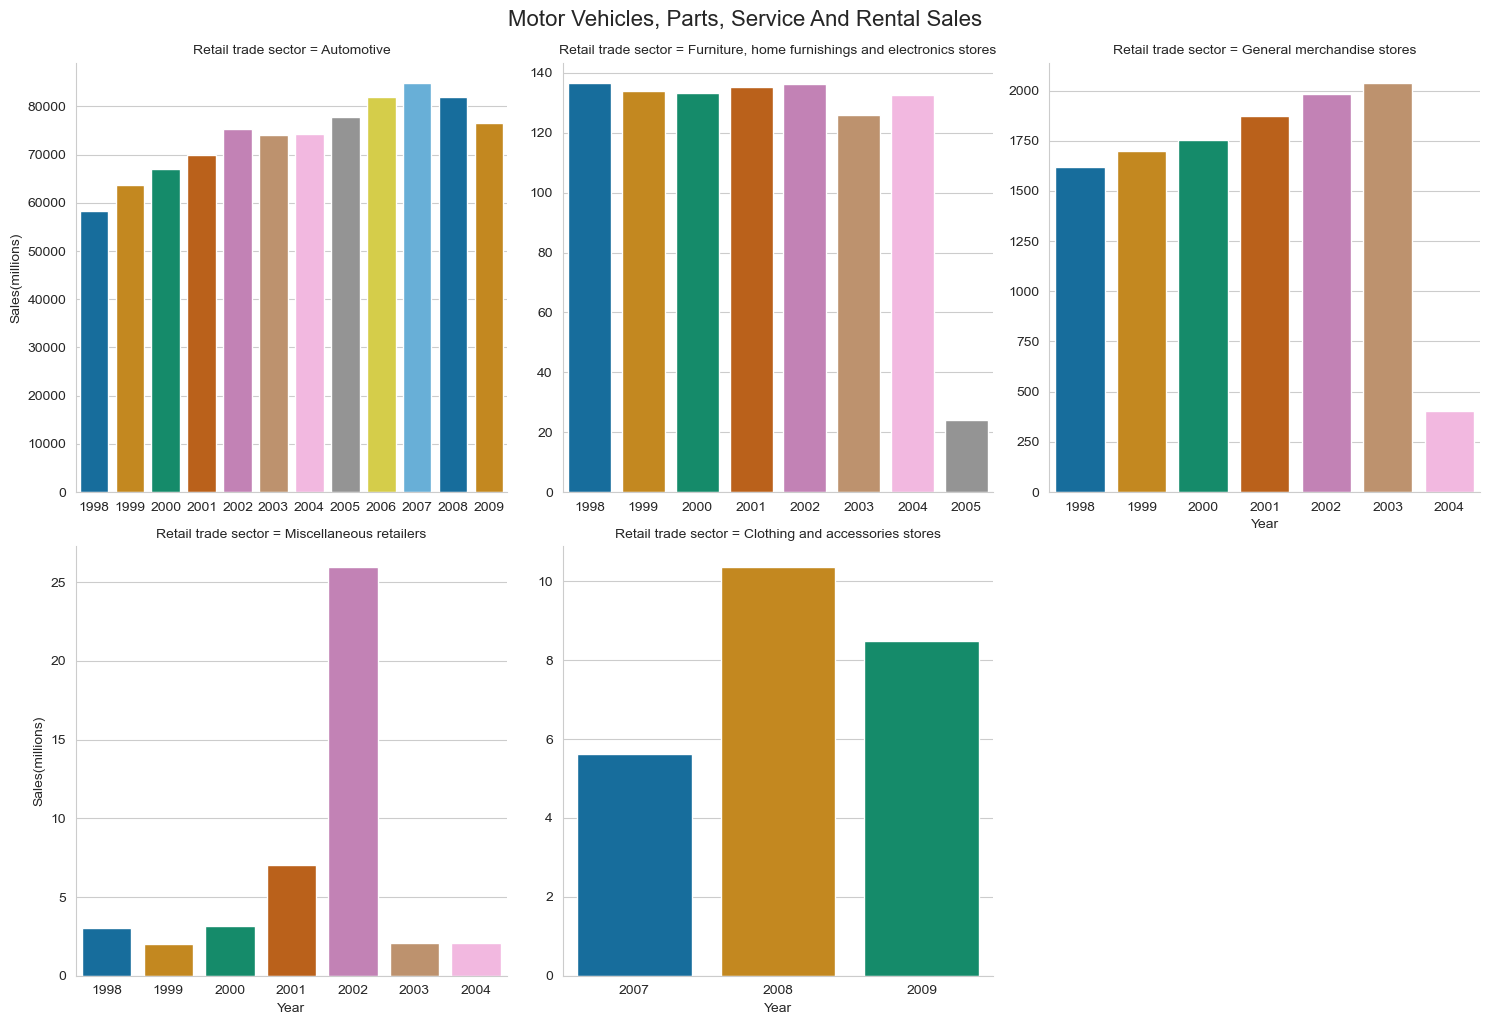

In [19]:
vehicles = salesDf[(salesDf["Retail commodity classification"]=="Motor vehicles, parts, service and rental") & 
                     (salesDf["Retail trade sector"]!="Total retail trade, all stores")]
vehicles = vehicles.groupby([vehicles["REF_DATE"].dt.to_period('Y'), "Retail trade sector"]).sum().reset_index()
vehicles = vehicles[vehicles["Sales"]!=0]

palette = "colorblind"
ax=sns.catplot(data=vehicles, x="REF_DATE", y="Sales", col="Retail trade sector", kind="bar",sharey=False,col_wrap=3,sharex=False, palette=palette )
ax.set_xlabels("Year")
ax.set_ylabels("Sales(millions)")
ax.fig.suptitle("Motor Vehicles, Parts, Service And Rental Sales",y=1.02, fontsize = 16)
sns.set_style("whitegrid")

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


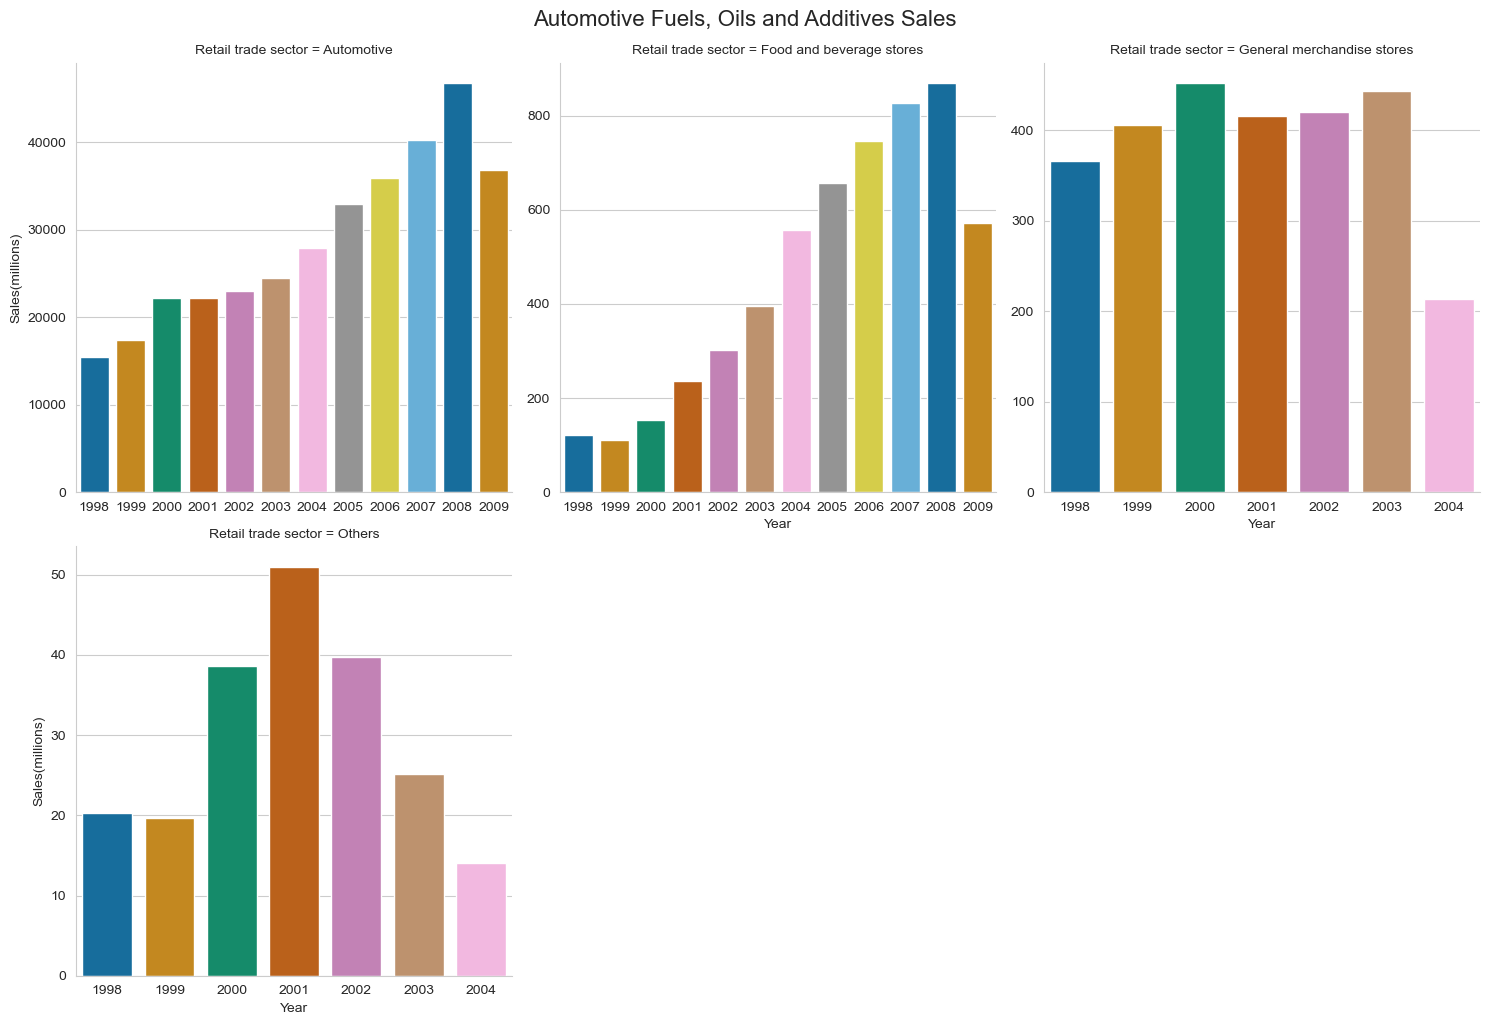

In [20]:
fuel = salesDf[(salesDf["Retail commodity classification"]=="Automotive fuels, oils and additives") & 
                     (salesDf["Retail trade sector"]!="Total retail trade, all stores")]
fuel = fuel.groupby([fuel["REF_DATE"].dt.to_period('Y'), "Retail trade sector"]).sum().reset_index()
fuel = fuel[fuel["Sales"]!=0]
fuelOthers = fuel[(fuel["Retail trade sector"]=="Pharmacies and personal care stores") | (fuel["Retail trade sector"]=="Miscellaneous retailers") | (fuel["Retail trade sector"]=="Building and outdoor home supplies stores")]
fuelOthers = fuelOthers.groupby("REF_DATE").sum().reset_index()
fuelOthers["Retail trade sector"] = "Others"
fuelOthers["Holiday Count"] = fuelOthers["Holiday Count"] /3
fuel = fuel[(fuel["Retail trade sector"]!="Pharmacies and personal care stores") & (fuel["Retail trade sector"]!="Miscellaneous retailers") & (fuel["Retail trade sector"]!="Building and outdoor home supplies stores")]
fuel = pd.concat([fuel,fuelOthers])
palette = "colorblind"
g=sns.catplot(data=fuel, x="REF_DATE", y="Sales", col="Retail trade sector",col_wrap=3, kind="bar",sharey=False,sharex=False, palette=palette )
g.set_xlabels("Year")
g.set_ylabels("Sales(millions)")
g.fig.suptitle("Automotive Fuels, Oils and Additives Sales",y=1.02, fontsize = 16)
sns.set_style("whitegrid")


C:\Users\Admin\anaconda3\lib\site-packages\seaborn\categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


Text(0.5, 1.02, 'Clothing, footwear and accessories Sales')

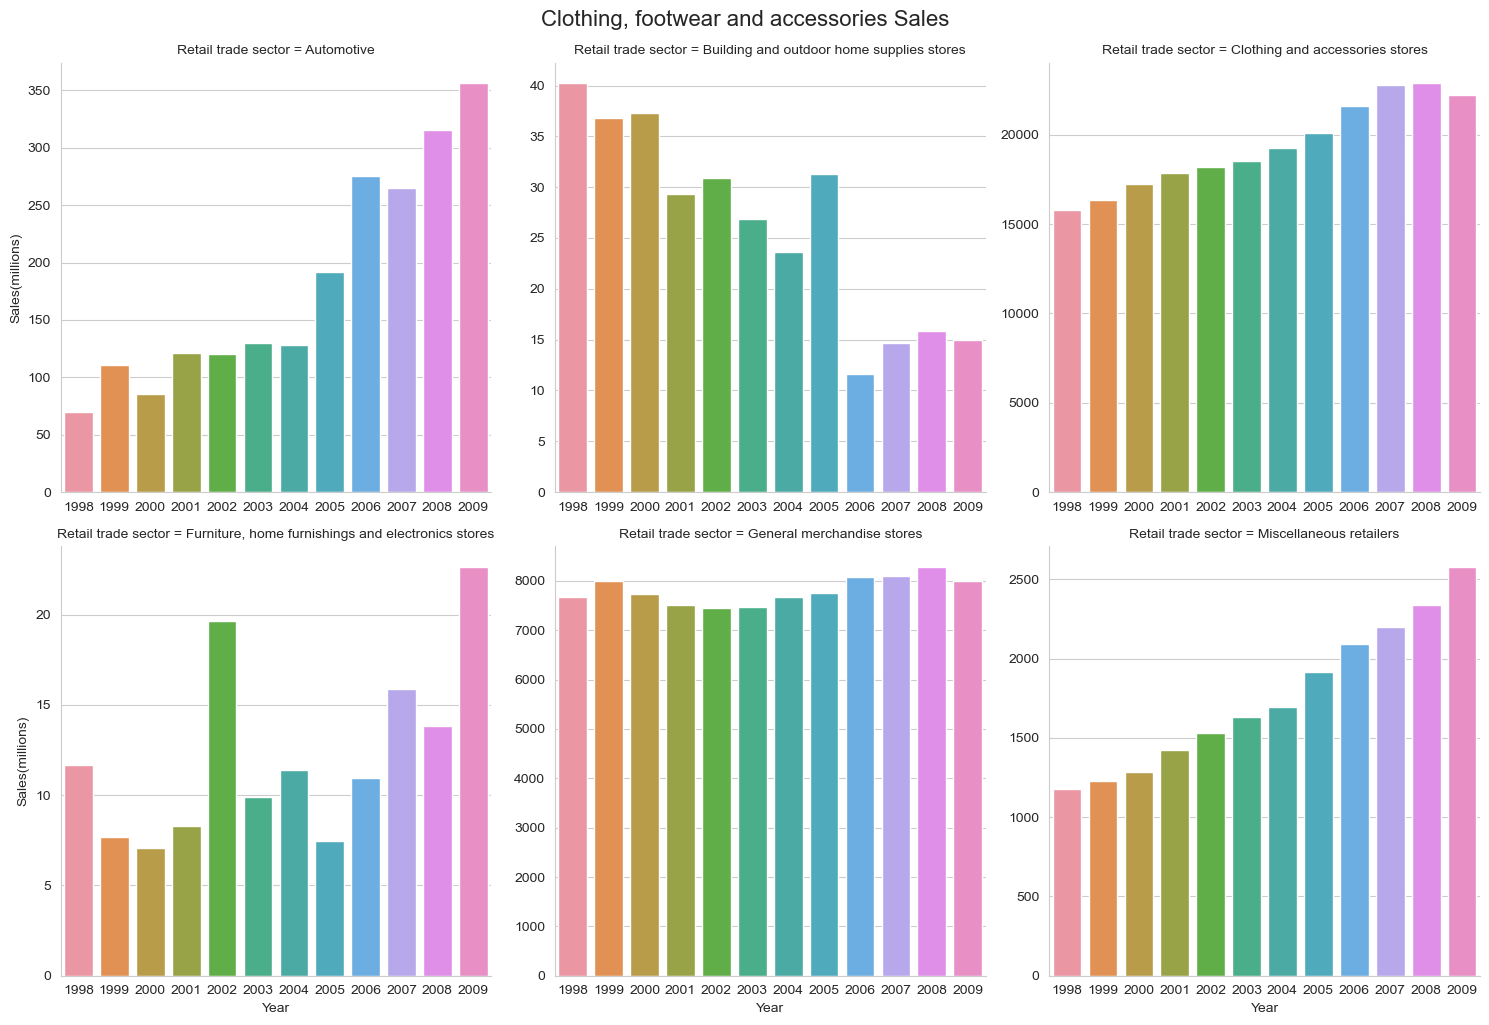

In [21]:
clothAndfoot = salesDf[(salesDf["Retail commodity classification"]=="Clothing, footwear and accessories") & (salesDf["Retail trade sector"]!="Total retail trade, all stores")]
clothAndfoot = clothAndfoot.groupby([clothAndfoot["REF_DATE"].dt.to_period('Y'), "Retail trade sector"]).sum().reset_index()
clothAndfoot = clothAndfoot[clothAndfoot["Sales"]!=0]
sns.set_style("whitegrid")
sns.set_palette("colorblind")
g = sns.catplot(data=clothAndfoot, x="REF_DATE", y="Sales", col="Retail trade sector", sharex=False, sharey=False, kind="bar", col_wrap=3)
g.set_xlabels("Year")
g.set_ylabels("Sales(millions)")
g.fig.suptitle("Clothing, footwear and accessories Sales",y=1.02, fontsize = 16)